# Sorting Networks with HierarQcal

Sorting Networks are networks of comparators designed specifically for sorting. A comparator is a device with two inputs $x$ and $y$ and two
outputs $x'$ and $y'$. For an increasing comparator, $x' = min(x, y)$ and $y' = max(x, y)$; and vice-versa. We will denote an increasing comparator by $\oplus$ or $\bullet$ and a decreasing comparator by $\ominus$ as shown in the image below. By default, $\oplus$ is the comparator used unless stated otherwise. The time complexity of the network is proportional to its depth. The number of comparisons in the network is also used as a metric to define the efficiency of the network.

<div align="center">
<img src='./sorting_net_assets/comparator.png' width=200 />
</div>

Below is an example of a sorting network (aka Knuth diagram) to sort an array of size 4. The comparator here swaps the values if and only if the top wire's value is greater or equal to the bottom wire's value (increasing comparator).

<div align="center">
<img src='https://upload.wikimedia.org/wikipedia/commons/9/9b/SimpleSortingNetworkFullOperation.svg' width=700 />
</div>

In this tutorial, we will build Bubble, Insertion and Bitonic sorting networks using HierarQcal. It will become evident how HierarQcal simplifies building sorting networks.

In [1]:
from hierarqcal import (
    Qcycle,
    Qinit,
    Qmask,
    Qunmask,
    plot_circuit,
    Qunitary,
)
import sympy as sp
import numpy as np

We now define the two comparators that will be used in the sorting networks.

In [2]:
def increasing_comparator(bits, symbols=None, state=None):
    v1, v2 = state[bits[0]], state[bits[1]]
    if v1 > v2:
        state[bits[0]], state[bits[1]] = v2, v1
    return state


def decreasing_comparator(bits, symbols=None, state=None):
    v1, v2 = state[bits[0]], state[bits[1]]
    if v1 < v2:
        state[bits[0]], state[bits[1]] = v2, v1
    return state


# Create 2 qubit unitaries of the comparators
i_comparator = Qunitary(increasing_comparator, n_symbols=0, arity=2)
d_comparator = Qunitary(decreasing_comparator, n_symbols=0, arity=2)

## Bubble Network

This is based on the bubble sort algorithm which compares every adjacent pair of elements and swaps them if they are not in the right order (the top wire value is larger than the bottom wire value). In our network, the topmost wire (indexed 0) denotes the first element. After each iteration, one less element (the last one) is needed to be compared until there are no more elements left to be compared. 

Since the bubble network compares adjacent pairs in every iteration, we can easily create such a network using the `Qcycle` primitive of HierarQcal.

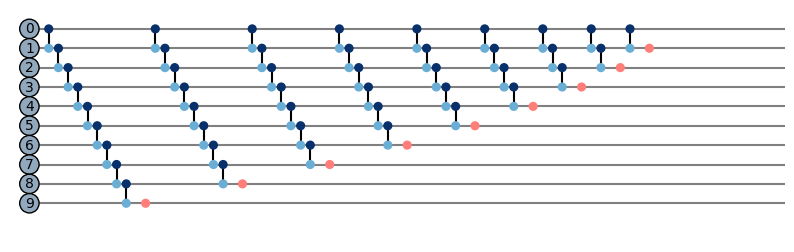

Starting array: [8, 5, 2, 1, 3, 4, 6, 7, 7, 7]
Sorted array: [1, 2, 3, 4, 5, 6, 7, 7, 7, 8]


In [3]:
array = [8, 5, 2, 1, 3, 4, 6, 7, 7, 7]
nb = len(array)  # number of indices

bubble_net = (
    Qcycle(stride=1, step=1, offset=0, mapping=i_comparator, boundary="open")
    + Qmask("*1")  # Ignore the last element in every iteration
) * (nb - 1)

hierq = Qinit(nb, state=array.copy()) + bubble_net

plot_circuit(hierq, plot_width=40)
sorted_array = hierq()

print(f"Starting array: {array}\nSorted array: {sorted_array}")

## Insertion Network

Insertion sort is a simple sorting algorithm that builds the final sorted array (or list) one item at a time by comparisons. The idea is to have two sets, sorted and unsorted. At every iteration, it removes one element from the unsorted part, finds the location it belongs within the sorted list, and inserts it there.

To create the insertion network, we define a function `insert` which, for a given index `i`, finds and inserts the element at that index at the right place in the sorted part. It does so by first masking all the elements after `i` and comparing the element at `i` with the elements in the sorted part of the array. Finally, it unmasks the masked part.

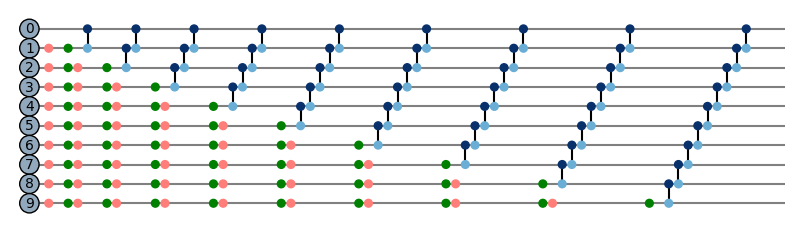

Starting array: [8, 5, 2, 1, 3, 4, 6, 7, 7, 7]
Sorted array: [1, 2, 3, 4, 5, 6, 7, 7, 7, 8]


In [4]:
insert = (
    lambda i: Qmask("0" * (i + 1) + "!")
    + Qcycle(
        stride=1,
        step=1,
        offset=0,
        mapping=i_comparator,
        boundary="open",
        edge_order=[-1],
    )
    + Qunmask("previous")
)

insertion_net = insert(0)
for i in range(1, nb):
    insertion_net += insert(i)

hierq = Qinit(nb, state=array.copy()) + insertion_net

plot_circuit(hierq, plot_width=40)
sorted_array = hierq()

print(f"Starting array: {array}\nSorted array: {sorted_array}")

## Extending Insertion and Bubble networks

Building sorting networks of any size is straightforward using techniques like insertion and selection. Imagine you already have a network that sorts $n$ numbers. To handle $n+1$ numbers, you can either insert the new number into the existing network (like in insertion sort) or find the smallest number first and sort the rest (like in bubble sort). Both approaches work and can be built upon recursively.

<div align="center">
    <div><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/6/66/Recursive-insertion-sorting-network.svg/1280px-Recursive-insertion-sorting-network.svg.png' alt='extending network based on insertion sort' width=300 /></div>
    <div>This sorting network recursively sorts the first part (n items), <br> then inserts the remaining element, similar to insertion sort.</div>
</div>

<div align="center">
    <div><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/e/e5/Recursive-bubble-sorting-network.svg/1280px-Recursive-bubble-sorting-network.svg.png' alt='extending network based on insertion sort' width=300 /></div>
    <div>Sorts like bubble sort, iteratively sinking the largest value <br> and then sorting the remaining elements.</div>
</div>

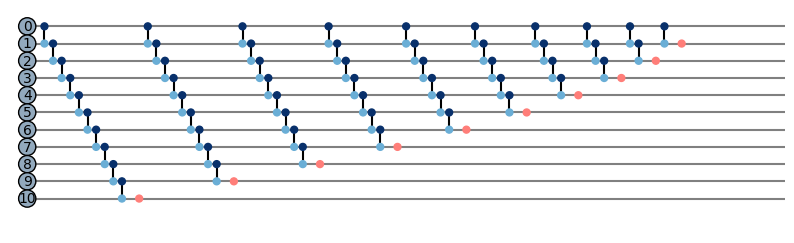

Starting array: [8, 5, 2, 1, 3, 9, 4, 6, 7, 7, 7]
Sorted array: [1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 9]


In [5]:
# Extending bubble network to incorporate one more element

array = [8, 5, 2, 1, 3, 9, 4, 6, 7, 7, 7]
nb = len(array)

ex_hierq = Qinit(nb, state=array.copy())
ex_hierq += Qcycle(
    stride=1, step=1, offset=0, mapping=i_comparator, boundary="open"
) + Qmask("*1")
ex_hierq += bubble_net

plot_circuit(ex_hierq, plot_width=45)
sorted_array = ex_hierq()

print(f"Starting array: {array}\nSorted array: {sorted_array}")

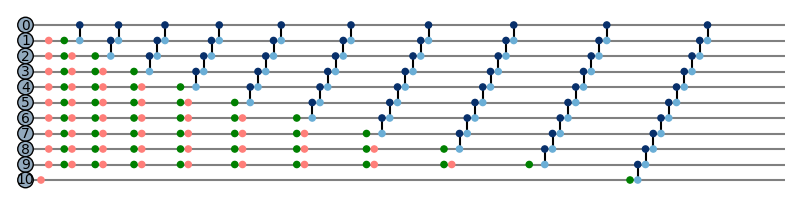

Starting array: [8, 5, 2, 1, 3, 9, 4, 6, 7, 7, 7]
Sorted array: [1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 9]


In [6]:
# Extending insertion network to incorporate one more element

ex_hierq = Qinit(nb, state=array.copy())
ex_hierq += Qmask("*1")
ex_hierq += insertion_net
ex_hierq += Qunmask("!")
ex_hierq += Qcycle(
    stride=1, step=1, offset=0, mapping=i_comparator, boundary="open", edge_order=[-1]
)

plot_circuit(ex_hierq, plot_width=50)
sorted_array = ex_hierq()

print(f"Starting array: {array}\nSorted array: {sorted_array}")

## Bitonic Sorter

### Sorting a Bitonic Sequence

A bitonic sequence has two tones – increasing and decreasing, or vice versa. Any cyclic rotation of such networks is also considered bitonic. For example, $[1,3,5,7,5,3,1]$ is a bitonic sequence as it first increases and then decreases. $[5,7,5,3,1,1,3]$ is also a bitonic sequence (circular shift of the first bitonic sequence). For this tutorial, without loss of generality, we will assume bitonic sequences of size in powers of 2, where half of the sequence is increasing and the other half is decreasing.

Consider a bitonic sequence $s = [x_0, x_1, \dots x_{n-1}]$ such that $x_0 \leq \dots \leq x_{n/2 - 1}$ and $x_{n/2} \geq \dots \geq x_{n-1}$. Now consider the following subsequences

$$
s_1 = [\min(x_0, x_{n/2}), \min(x_1, x_{n/2 + 1}) \dots \min(x_{n/2 - 1}, x_{n-1})]
$$
$$
s_2 = [\max(x_0, x_{n/2}), \max(x_1, x_{n/2 + 1}) \dots \max(x_{n/2 - 1}, x_{n-1})]
$$

Note that $s_1$ and $s_2$ are both bitonic and each element of $s_1$ is less than every element in $s_2$. We can apply the procedure recursively on $s_1$ and $s_2$ to get the sorted sequence. The below example shows sorting a bitonic sequence of size 16 with $\log 16$ operations.

<div align="center">
<img src='./sorting_net_assets/bitonic_sort.png' width=800 />
</div>

Given a bitonic sequence, we can build such a network and call it a bitonic merging network. We denote a bitonic merging network with $n$ inputs by $\oplus$ BM[n], where $\oplus$ denotes that an increasing comparator is used throughout the network. For an input of size 16, the network ($\oplus$ BM[16]) is shown below. Every box shows one iteration of the merging algorithm

<div align="center">
<img src='./sorting_net_assets/bitonic_merging_network.png' width=700 />
</div>

### Implementation with HierarQcal

As we can see in the figure above, we can implement a bitonic merging network using the `Qcycle` primitive. In this case, we will use Qcycle two times in a nested fashion as shown below.

```python
Qcycle(
    ...
    mapping=Qcycle(
                ...
                mapping=comparator
                ...
            )
)
```
The innermost `Qcycle` will be used to construct the merging networks on subsequences and the outermost `Qcycle` will repeat them for other subsequences. For example, in the above figure, in the second box, the merging network from wires `0000` till `0111` is created using the innermost `Qcycle` and the same is repeated on wires `1000` till `1111` using the outermost `Qcycle`.

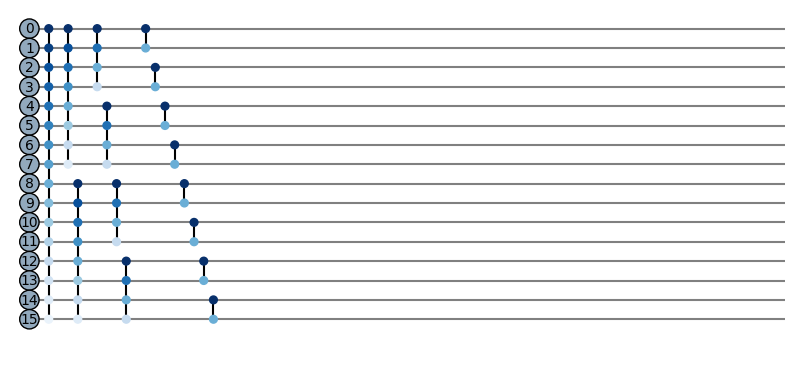

Starting array: [3, 5, 8, 9, 10, 12, 14, 20, 95, 90, 60, 40, 35, 23, 18, 0]
Sorted array: [0, 3, 5, 8, 9, 10, 12, 14, 18, 20, 23, 35, 40, 60, 90, 95]


In [7]:
bitonic_array = [3, 5, 8, 9, 10, 12, 14, 20, 95, 90, 60, 40, 35, 23, 18, 0]
nb = len(bitonic_array)

# Inner Qcycle
bitonic_merge = lambda n, stride, comp: Qinit(n) + Qcycle(
    stride=stride, step=1, offset=0, mapping=comp, boundary="open"
)

# Outer Qcycle
bitonic_merge_cycle = lambda n, stride1, stride2, step, comp, off=0: Qcycle(
    stride=stride2,
    step=step,
    offset=off,
    mapping=bitonic_merge(n, stride1, comp),
    boundary="open",
)


# This function is the BM[n] and uses the inner and outer qcycles to make a
# complete bitonic merging network over the given wires.
# The comparator is passed as an argument.
def bitonic_merging_network(nqubits, comp=i_comparator):
    net = bitonic_merge_cycle(nqubits, nqubits // 2, 1, nqubits, comp)
    i = nqubits // 2
    while i >= 2:
        net += bitonic_merge_cycle(i, i // 2, 1, i, comp)
        i = i // 2
    return net


hierq = Qinit(nb, state=bitonic_array.copy()) + bitonic_merging_network(nb)

plot_circuit(hierq, plot_width=40)
sorted_array = hierq()

print(f"Starting array: {bitonic_array}\nSorted array: {sorted_array}")

### Sorting an unsorted sequence

Sorting an unsorted sequence with a bitonic merge involves a two-step process. First, we need to transform the original sequence into a bitonic sequence. Note that a sequence of length 2 is already a bitonic sequence. To create a bitonic sequence of length 4, we sort the first two elements in ascending order using $\oplus$ BM[2] and the next two elements in descending order using $\ominus$ BM[2]. This process can be applied recursively to create bitonic sequences of any size.

The below image shows the complete bitonic sort of an unsorted sequence. The last merging network $\oplus$ BM[16] sorts the input.

<div align="center">
<img src='./sorting_net_assets/bitonic_sort_network.png' width=700 />
</div>

### Implementation with HierarQcal

Since we have already built the function `bitonic_merging_network`, we can make use of it. From the above image, note that, in the first iteration, $\oplus$ BM[2] is used in a cycle. $\ominus$ BM[2] is repeated similarly. This means that we need to use the `Qcycle` primitive with `bitonic_merging_network` as the `mapping` argument (essentially 3 nested `Qcycle`). We create a function `BMCycle` for the same.

In [8]:
def BMCycle(step, off, nqubits, comp=i_comparator):
    return Qcycle(
        stride=1,
        step=step,
        offset=off,
        mapping=Qinit(nqubits) + bitonic_merging_network(nqubits, comp),
        boundary="open",
    )

We can now create a function `create_bitonic_sequence` which uses the `BMCycle` function and returns a network which, given an unsorted sequence returns a bitonic sequence upon execution.

In [9]:
def create_bitonic_sequence(nqubits):
    i = 2
    seq = BMCycle(2 * i, 0, i)
    seq += BMCycle(2 * i, i, i, d_comparator)
    i *= 2
    while i < nqubits:
        seq += BMCycle(2 * i, 0, i)
        seq += BMCycle(2 * i, i, i, d_comparator)
        i *= 2
    return seq

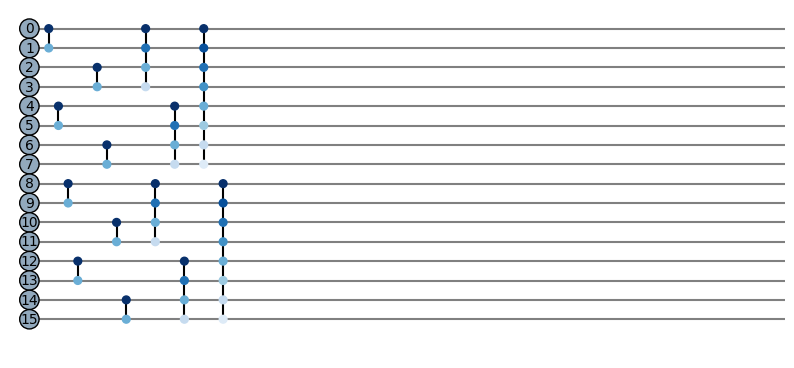

Starting array: [10, 20, 5, 9, 3, 8, 12, 14, 90, 0, 60, 40, 23, 35, 95, 18]
Bitonic array: [3, 5, 8, 9, 10, 12, 14, 20, 95, 90, 60, 40, 35, 23, 18, 0]


In [10]:
array = [10, 20, 5, 9, 3, 8, 12, 14, 90, 0, 60, 40, 23, 35, 95, 18]
nb = len(array)

hierq = Qinit(nb, state=array.copy()) + create_bitonic_sequence(nb)

plot_circuit(hierq, plot_width=40)

bitonic_array = hierq()
print(f"Starting array: {array}\nBitonic array: {bitonic_array}")

The output indeed is a bitonic sequence. For a complete bitonic sort, we need to add the final bitonic merging network i.e. $\oplus$ BM[n] where $n$ is the size of the array (here 16).

In [11]:
def bitonic_sort(nqubits):
    seq = create_bitonic_sequence(nqubits)
    seq += BMCycle(2 * nqubits, 0, nqubits)
    return seq

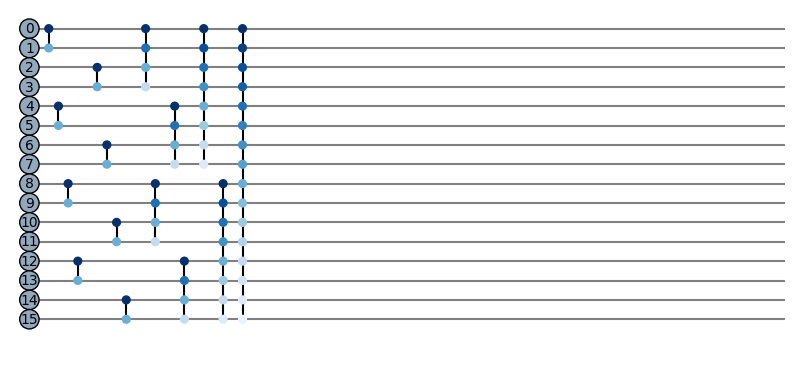

Starting array: [10, 20, 5, 9, 3, 8, 12, 14, 90, 0, 60, 40, 23, 35, 95, 18]
Sorted array: [0, 3, 5, 8, 9, 10, 12, 14, 18, 20, 23, 35, 40, 60, 90, 95]


In [12]:
hierq = Qinit(len(array), state=array.copy()) + bitonic_sort(len(array))
plot_circuit(hierq, plot_width=40)
sorted_array = hierq()
print(f"Starting array: {array}\nSorted array: {sorted_array}")

## Conclusion

In this tutorial, we utilized HierarQcal to create and execute sorting networks including insertion, bubble and bitonic sort. With bitonic sort, we also learnt how to use nested `Qcycle` primitive from HierarQcal. We also covered sorting an unsorted sequence using bitonic sort by first creating a bitonic sequence and then using the $\oplus$ BM[n].

## References

1. Chapter 9. Sorting, [Introduction to Parallel Computing](https://www.cs.purdue.edu/homes/ayg/book/Slides/), Ananth Grama, Purdue University.
2. [Sorting network](https://en.wikipedia.org/wiki/Sorting_network), Wikipedia.